In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

In [5]:
url = 'drive/MyDrive/dataset/multilabel_comment_dataset.csv'

dataset = pd.read_csv(url, encoding = 'utf8')

dataset.head()

,comment_text,harmful,severe,obscene,threat,insult,discriminate,normal
0,bangladeshi cyclists i notice you did a name c...,0,0,0,0,0,0,1
1,in the ass bitch fucking cock sucker,1,1,1,0,1,1,0
2,ur so immature frnziim and ur not evn debating...,1,0,1,0,1,1,0
3,hi goodday i have noted that qwyrxian has weig...,0,0,0,0,0,0,1
4,for fucks sake just fucking stop you spastic a...,1,1,1,0,1,0,0


In [12]:
raw_train, raw_validation, raw_test = np.split(dataset.sample(frac=1), [int(0.7*len(dataset)), int(0.9*len(dataset))])

print(len(raw_train), 'training examples')
print(len(raw_validation), 'validation examples')
print(len(raw_test), 'test examples')

def df_to_dataset(dataframe, shuffle=True, batch_size=2048):
  df = dataframe.copy()
  labels = df[['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal']].values
  df = df['comment_text']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

raw_train_ds = df_to_dataset(raw_train)
raw_val_ds = df_to_dataset(raw_validation)
raw_test_ds = df_to_dataset(raw_test)

200652 training examples
57329 validation examples
28665 test examples


In [14]:
max_features = 220000
sequence_length = 250

def custom_standardization(input):
  lowercase = tf.strings.lower(input)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_sequence_length=sequence_length,
    output_mode='int'
)

train_text = raw_train_ds.map(lambda text, labels: text)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
# nums of character in a word
embedding_dim = 26

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.LSTM(32, return_sequences=True),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(16, activation='relu'),
  layers.Dense(7, activation='sigmoid')
])

model.summary()

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 26)          5720000   
                                                                 
 dropout_9 (Dropout)         (None, None, 26)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          7552      
                                                                 
 global_average_pooling1d_3  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                      

In [47]:
epochs = 2
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
63/98 [==================>...........] - ETA: 1:30 - loss: 0.2891 - binary_accuracy: 0.8675

KeyboardInterrupt: 

In [48]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

14/14 [==============================] - 14s 955ms/step - loss: 0.2842 - binary_accuracy: 0.8695
Loss:  0.2841992974281311
Accuracy:  0.8694624900817871


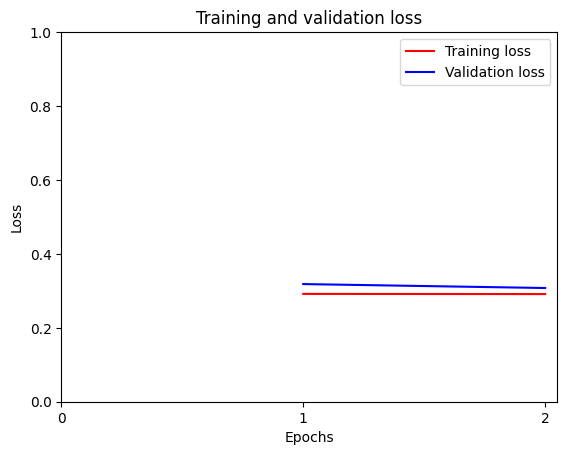

In [49]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend()

plt.show()

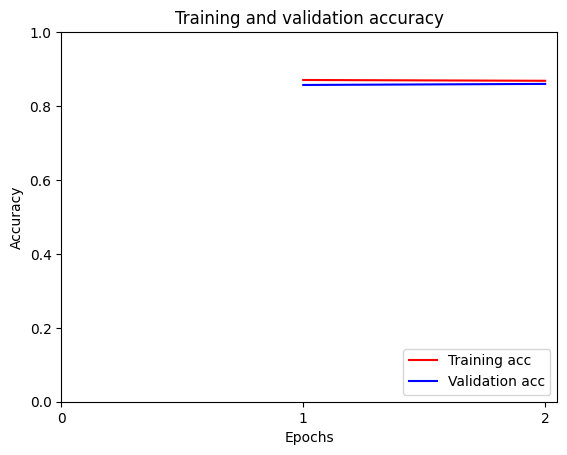

In [50]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, len(acc) + 1, 1))
plt.legend(loc='lower right')

plt.show()

In [51]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

1/1 [==============================] - 1s 661ms/step
Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,


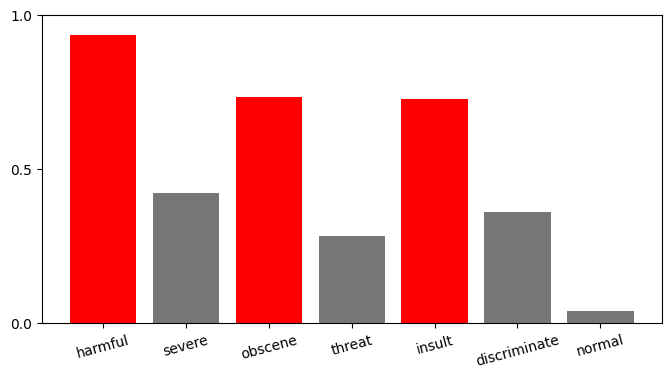

Dear god this site is horrible.


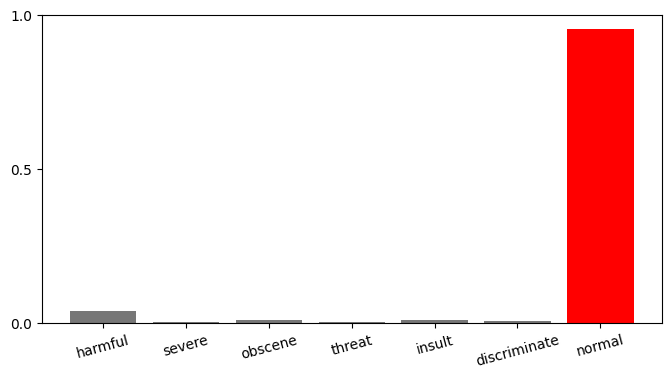

Only a fool can believe in such numbers.


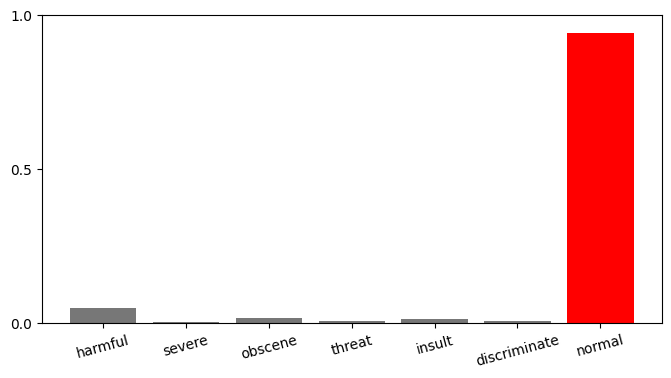

I have indefinitely blocked this account.


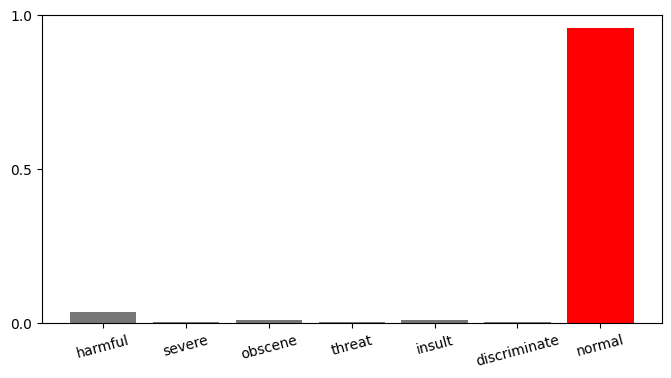

Please stop. If you continue to vandalize TikTok, as you did to Homosexuality, you will be blocked from editing.


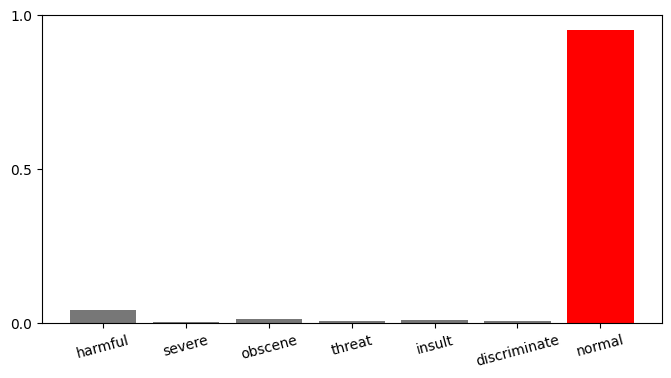

I've deleted the page , as we have no evidence that you are the person named on that page, and its content goes against Wikipedia's policies for the use of user pages.


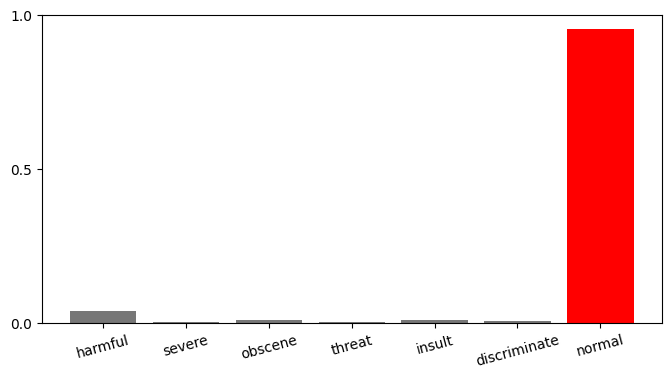

The word bitch is from the Old Norse Bikkjuna meaning female of the dog of unknown origin, Grimm derives the Old Norse words from Lapp Pittja, But OED notes that the converse is equally possible. 


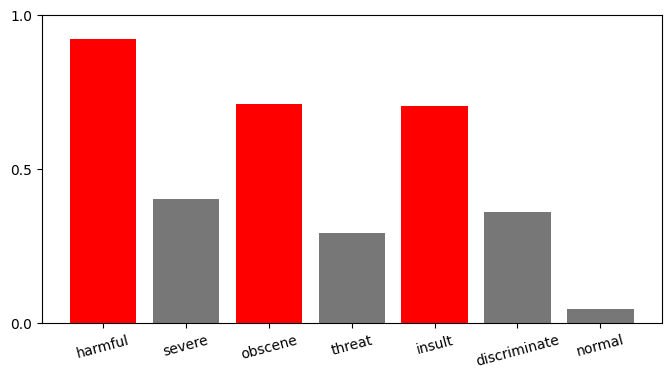

The adj. Bitchy was first seen in 1925.


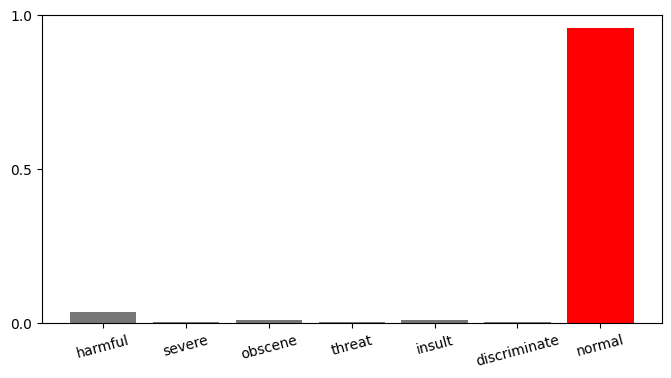

The word bitch is actually only offencive in American and Canadian English. In most other English variants bitch maintains it's correct definition - female canine. People have argued that bitch is different because it is used as an insult - but so is pig, dog, cow and others. These are not considered profane, so why is bitch? As far as I am concerned, there is nothing to reclaim as bitch simply means a female canine.


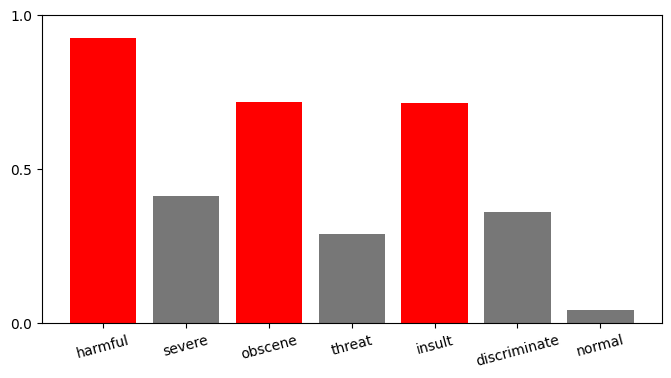

Hi... Bitch


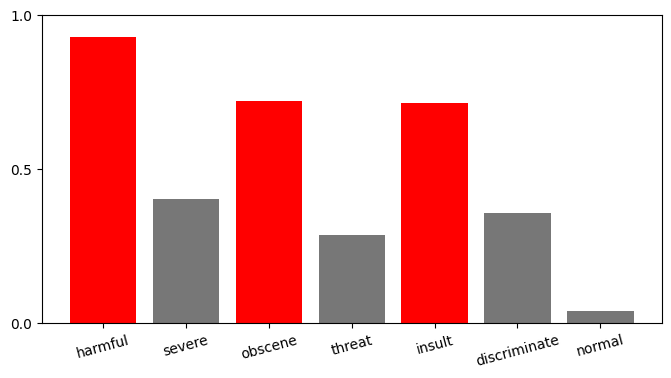

HIS DICK IS MIGHTY FINE!!!!!!!!!!


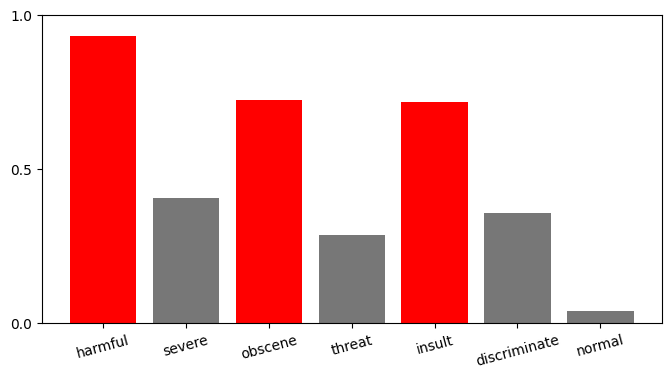

Discard All said previously... We love you Carlos... I LOVE YOU! I WANT TO RAPE YOU O Just Kidding


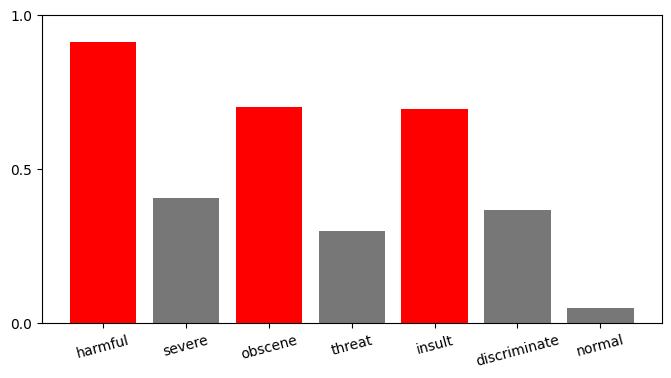

dffhdfdfghldfugdfhdiufhudifhgudighdfu fuck yo bfhiffbifbdufh wilvingstone simplice


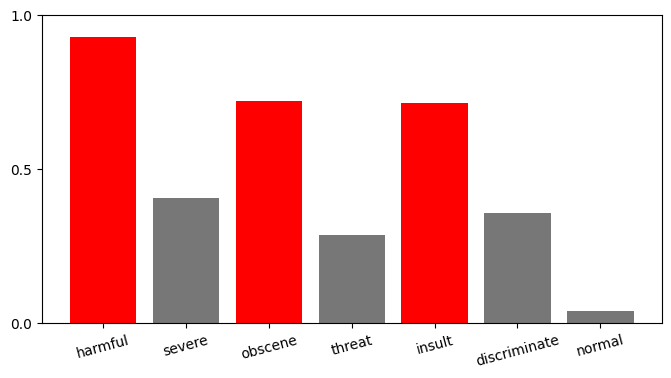

In [52]:
inputs = [
  "Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
  "Dear god this site is horrible.",
  "Only a fool can believe in such numbers.",
  "I have indefinitely blocked this account.",
  "Please stop. If you continue to vandalize TikTok, as you did to Homosexuality, you will be blocked from editing.",
  "I've deleted the page , as we have no evidence that you are the person named on that page, and its content goes against Wikipedia's policies for the use of user pages.",
  "The word bitch is from the Old Norse Bikkjuna meaning female of the dog of unknown origin, Grimm derives the Old Norse words from Lapp Pittja, But OED notes that the converse is equally possible. ",
  "The adj. Bitchy was first seen in 1925.",
  "The word bitch is actually only offencive in American and Canadian English. In most other English variants bitch maintains it's correct definition - female canine. People have argued that bitch is different because it is used as an insult - but so is pig, dog, cow and others. These are not considered profane, so why is bitch? As far as I am concerned, there is nothing to reclaim as bitch simply means a female canine.",
  "Hi... Bitch",
  "HIS DICK IS MIGHTY FINE!!!!!!!!!!",
  "Discard All said previously... We love you Carlos... I LOVE YOU! I WANT TO RAPE YOU O Just Kidding",
  "dffhdfdfghldfugdfhdiufhudifhgudighdfu fuck yo bfhiffbifbdufh wilvingstone simplice",
]

examples = tf.constant(inputs)
def plot_value_array(prediction):
  colors=["red" if pred >= 0.5 else "#777777" for pred in prediction]
  thisplot = plt.bar(range(len(prediction)), prediction, color=colors)
  plt.xticks(range(len(prediction)), ['harmful', 'severe', 'obscene', 'threat', 'insult', 'discriminate', 'normal'], rotation=15)
  plt.yticks([0, 0.5, 1])
  plt.ylim([0, 1])

predictions = export_model.predict(examples)

for i in range(len(inputs)):
  plt.figure(figsize=(8, 4))
  print(inputs[i])
  plot_value_array(predictions[i])
  plt.show()